## Part 2

# Chapter 4 - Improving embeddings with biased random walks

Biased random walks

/Users/ishaanpaul/Desktop/Extras/Graph-Neural-Network/.venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


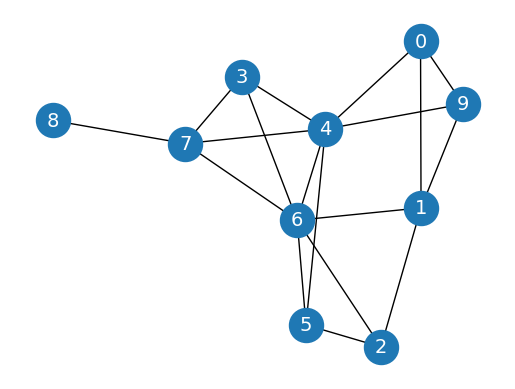

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

# Plot graph
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [2]:
import random
random.seed(0)
import numpy as np
np.random.seed(0)

In [3]:
def next_node(previous, current, p, q):
    alphas = []

    # Get the neighboring nodes
    neighbors = list(G.neighbors(current))
    
    # Calculate the appropriate alpha value for each neighbor
    for neighbor in neighbors:
        # Distance = 0: probability to return to the previous node
        if neighbor == previous:
            alpha = 1/p
        # Distance = 1: probability of visiting a local node
        elif G.has_edge(neighbor, previous):
            alpha = 1
        # Distance = 2: probability to explore an unknown node
        else:
            alpha = 1/q
        alphas.append(alpha)

    # Normalize the alpha values to create transition probabilities
    probs = [alpha / sum(alphas) for alpha in alphas]
    
    # Randomly select the new node based on the transition probabilities
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [4]:
def random_walk(start, length, p, q):
    walk = [start]
    
    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)
    
    return walk

In [5]:
random_walk(0, 8, p=1, q=1)

[0, 4, 7, 6, 4, 5, 4, 5, 6]

In [6]:
#Bias it to go to the previous node
random_walk(0, 8, p=1, q=10)

[0, 9, 1, 9, 1, 9, 1, 0, 1]

In [7]:
#Bias it such that it rarely goes to the previous node
#Increasing p increases the bias towards DFS.
random_walk(0, 8, p=10, q=1)

[0, 1, 9, 4, 7, 8, 7, 4, 6]

Implementing Node2Vec

In [8]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [9]:
G = nx.karate_club_graph()
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

In [10]:
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10, 3, 2))

In [11]:
node2vec = Word2Vec(walks,
    hs=1, # Hierarchical softmax
    sg=1, # Skip-gram
    vector_size=100,
    window=10,
    workers=2,
    min_count=1,
    seed=0)

In [12]:
node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

(185807, 897600)

In [13]:
# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
labels = np.array(labels)

In [14]:
# Train Node2Vec classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(node2vec.wv[train_mask], labels[train_mask])

RandomForestClassifier(random_state=0)

In [15]:
y_pred = clf.predict(node2vec.wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Node2Vec accuracy = {acc*100:.2f}%')

Node2Vec accuracy = 100.00%


Building a movie recommendation with RecSys

In [16]:
#Importing libraries and downloading the movielens dataset
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [17]:
import pandas as pd
ratings = pd.read_csv('ml-100k/u.data', sep='\t',
names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [18]:
movies = pd.read_csv('ml-100k/u.item', sep='|',
usecols=range(2), names=['movie_id', 'title'],
encoding='latin-1')

In [19]:
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [20]:
ratings = ratings[ratings.rating >= 4]
ratings

,user_id,movie_id,rating,unix_timestamp
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437


In [21]:
from collections import defaultdict

pairs = defaultdict(int)

# Loop through the entire list of users
for group in ratings.groupby("user_id"):
    # List of IDs of movies rated by the current user
    user_movies = list(group[1]["movie_id"])

    # Count every time two movies are seen together
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1

In [22]:
# Create a networkx graph
G = nx.Graph()

# Try to create an edge between movies that are liked together
for pair in pairs:
    movie1, movie2 = pair
    score = pairs[pair]

    # The edge is only created when the score is high enough
    if score >= 20:
        G.add_edge(movie1, movie2, weight=score)

print("Total number of graph nodes:", G.number_of_nodes())
print("Total number of graph edges:", G.number_of_edges())

Total number of graph nodes: 410
Total number of graph edges: 14936


In [23]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

/Users/ishaanpaul/Desktop/Extras/Graph-Neural-Network/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating walks (CPU: 1): 100%|██████████| 200/200 [00:12<00:00, 15.92it/s]


In [24]:
def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f'{title}: {id[1]:.2f}')

recommend('Star Wars (1977)')

Return of the Jedi (1983): 0.61
Raiders of the Lost Ark (1981): 0.55
Godfather, The (1972): 0.49
Indiana Jones and the Last Crusade (1989): 0.46
White Squall (1996): 0.44


# Chapter 5 - Including Node Features with Vanilla Neural Networks

In [25]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708


Processing...
Done!


In [26]:
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of features: 1433
Number of classes: 7


In [27]:
print(f'Graph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


Using Facebook Page-Page dataset 

In [28]:
from torch_geometric.datasets import FacebookPagePage
import torch
from torch_geometric.utils import to_dense_adj

In [29]:
dataset = FacebookPagePage(root=".")

Processing...
Done!


In [30]:
data = dataset[0]


In [31]:
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: FacebookPagePage()
-----------------------
Number of graphs: 1
Number of nodes: 22470
Number of features: 128
Number of classes: 4


In [32]:
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')


Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: True


In [39]:
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

Classifying nodes with vanilla neural networks:

In [33]:
import pandas as pd
df_x = pd.DataFrame(data.x.numpy())
df_x['label'] = pd.DataFrame(data.y)

In [34]:
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)

In [35]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

In [36]:
class MLP(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, dim_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [37]:
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)

MLP(
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4, bias=True)
)


In [40]:
# Train
mlp.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.373 | Train Acc: 33.05% | Val Loss: 1.38 | Val Acc: 32.27%
Epoch  20 | Train Loss: 0.658 | Train Acc: 73.82% | Val Loss: 0.68 | Val Acc: 72.29%
Epoch  40 | Train Loss: 0.573 | Train Acc: 77.02% | Val Loss: 0.62 | Val Acc: 74.89%
Epoch  60 | Train Loss: 0.546 | Train Acc: 78.20% | Val Loss: 0.61 | Val Acc: 75.74%
Epoch  80 | Train Loss: 0.529 | Train Acc: 78.87% | Val Loss: 0.60 | Val Acc: 76.04%
Epoch 100 | Train Loss: 0.516 | Train Acc: 79.46% | Val Loss: 0.61 | Val Acc: 75.89%


In [41]:
# Test
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%')


MLP test accuracy: 75.46%


In [42]:
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x

In [43]:
from torch_geometric.utils import to_dense_adj

adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [44]:
class VanillaGNN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)

    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, adjacency)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)

# Train
gnn.fit(data, epochs=100)

# Test
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)
Epoch   0 | Train Loss: 146.624 | Train Acc: 19.23% | Val Loss: 148.55 | Val Acc: 20.71%
Epoch  20 | Train Loss: 5.869 | Train Acc: 80.46% | Val Loss: 4.34 | Val Acc: 80.59%
Epoch  40 | Train Loss: 2.653 | Train Acc: 82.81% | Val Loss: 2.02 | Val Acc: 83.19%
Epoch  60 | Train Loss: 1.481 | Train Acc: 82.99% | Val Loss: 1.28 | Val Acc: 81.89%
Epoch  80 | Train Loss: 1.061 | Train Acc: 83.23% | Val Loss: 0.95 | Val Acc: 82.54%
Epoch 100 | Train Loss: 0.824 | Train Acc: 84.13% | Val Loss: 0.79 | Val Acc: 84.09%

GNN test accuracy: 83.27%


Facebook Page-Page dataset

In [45]:
# Dataset
dataset = FacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Adjacency matrix
adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency

# MLP
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)
mlp.fit(data, epochs=100)
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%\n')

# GCN
gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)
gnn.fit(data, epochs=100)
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4, bias=True)
)
Epoch   0 | Train Loss: 1.433 | Train Acc: 20.65% | Val Loss: 1.44 | Val Acc: 19.66%
Epoch  20 | Train Loss: 0.669 | Train Acc: 73.41% | Val Loss: 0.68 | Val Acc: 73.04%
Epoch  40 | Train Loss: 0.577 | Train Acc: 76.91% | Val Loss: 0.62 | Val Acc: 74.69%
Epoch  60 | Train Loss: 0.548 | Train Acc: 78.13% | Val Loss: 0.60 | Val Acc: 75.74%
Epoch  80 | Train Loss: 0.531 | Train Acc: 78.92% | Val Loss: 0.60 | Val Acc: 76.14%
Epoch 100 | Train Loss: 0.518 | Train Acc: 79.60% | Val Loss: 0.60 | Val Acc: 76.49%

MLP test accuracy: 75.05%

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)
Epoch   0 | Train Loss: 70.792 | Train Acc: 20.17% | Val Loss: 70.45 | Val Acc: 19.26%
Epoch  20 | Train Loss: 6.027 | 

## Therefore, we can conclude from the results with both datasets that using information from both the central node and its neighborhood creates a better model. Even a basic version of a GNN creates a better model for graph structures.

# Chapter 6 - Introducing Graph Convolutional Networks

In [47]:
#Representing degree matrix D
import numpy as np
D = np.array([
[3, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 2, 0],
[0, 0, 0, 2]
])

In [48]:
#Inverse of the matrix
np.linalg.inv(D)

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

In [49]:
#Creating an identity matrix of size 4, adding it to do to satisy the formula Dtilde ^ -1 = (D+I)^-1
np.linalg.inv(D + np.identity(4))

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

Defining adjacency matrix A and performing the matrix multiplications $\tilde{D}^{-1}\tilde{A}XW^{T}$ and $\tilde{A}\tilde{D}^{-1}XW^{T}$ to prove that they normalize the rows and columns of features respectively

In [50]:
A = np.array([
[1, 1, 1, 1],
[1, 1, 0, 0],
[1, 0, 1, 1],
[1, 0, 1, 1]
])
print(np.linalg.inv(D + np.identity(4)) @ A)

[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]


In [51]:
print(A @ np.linalg.inv(D + np.identity(4)))

[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]


The first option looks more appealing because it normalizes neighboring node features. However, features from nodes with a lot of neighbors spread very easily, unlike features from isolated nodes. We can perform a hybridization to counterbalance this effect. We obtain the formula $H = \tilde{D}^{-\frac{1}{2}}\tilde{A}^{T}\tilde{D}^{-\frac{1}{2}}XW^{T}$

## Comparing graph convolution and graph linear layers

In [52]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

In [53]:
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

In [54]:
degrees = degree(data.edge_index[0]).numpy()

In [56]:
#counting the number of nodes for each degree
numbers = Counter(degrees)

<BarContainer object of 37 artists>

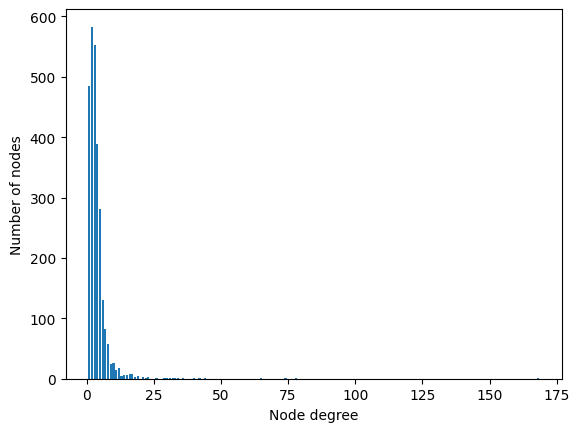

In [57]:
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

The distribution of node degree vs number of nodes is heavily skewed with a heavy tail

In [58]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [60]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

In [61]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [67]:
# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, epochs=100)

# Test
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.950 | Train Acc: 14.29% | Val Loss: 1.94 | Val Acc: 27.40%
Epoch  20 | Train Loss: 0.098 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 78.40%
Epoch  40 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 0.70 | Val Acc: 77.80%
Epoch  60 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.69 | Val Acc: 77.20%
Epoch  80 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.69 | Val Acc: 78.00%
Epoch 100 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.69 | Val Acc: 77.00%

GCN test accuracy: 80.40%



Facebook Page Dataset

In [68]:
# Load Facebook Page-Page
dataset = FacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Train GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 1.500 | Train Acc: 20.31% | Val Loss: 1.50 | Val Acc: 20.26%
Epoch  20 | Train Loss: 0.456 | Train Acc: 84.99% | Val Loss: 0.45 | Val Acc: 85.64%
Epoch  40 | Train Loss: 0.318 | Train Acc: 89.91% | Val Loss: 0.32 | Val Acc: 89.69%
Epoch  60 | Train Loss: 0.277 | Train Acc: 91.42% | Val Loss: 0.28 | Val Acc: 91.10%
Epoch  80 | Train Loss: 0.256 | Train Acc: 92.28% | Val Loss: 0.26 | Val Acc: 92.25%
Epoch 100 | Train Loss: 0.242 | Train Acc: 92.87% | Val Loss: 0.25 | Val Acc: 92.90%

GCN test accuracy: 91.86%



Predicting web traffic with node regression with Wikipedia Network Dataset

In [71]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

dataset = WikipediaNetwork(root=".", name="chameleon", transform = T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


In [72]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [73]:
import pandas as pd

df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
values = np.log10(df['target'])
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

<BarContainer object of 63 artists>

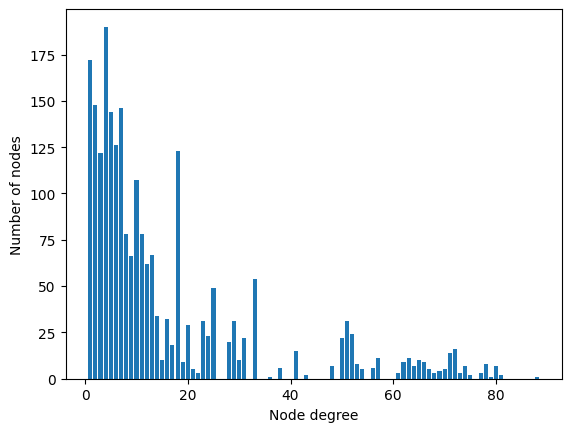

In [74]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

/var/folders/bb/1pgmng2s0xl2b26dxfj33phm0000gn/T/ipykernel_78904/2660044443.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(df['target'], fit=norm)


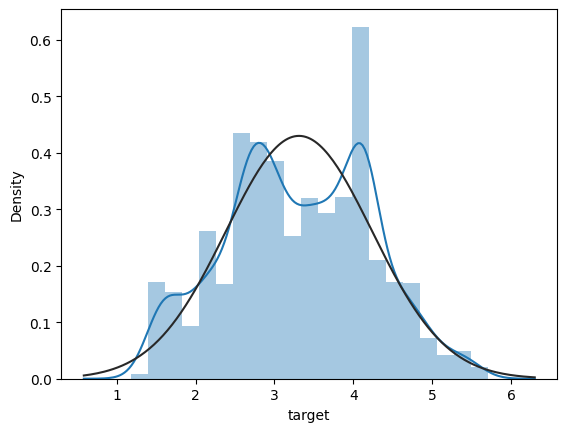

In [94]:
import seaborn as sns
from scipy.stats import norm

df['target'] = values
fig = sns.distplot(df['target'], fit=norm)

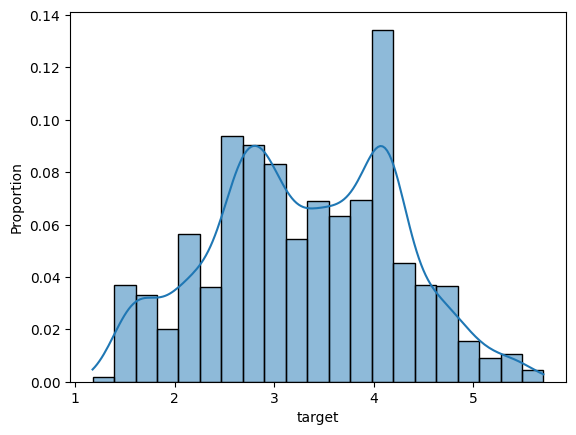

In [88]:
import seaborn as sns

df['target'] = values
fig = sns.histplot(df['target'], stat='proportion', kde=True)

The distribution of the target values is not normal but it is not exponential as in the case of node degrees. The model should work well with this data

In [76]:
#Creating a 3 layer GCN with decreasing dimensions
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

    def fit(self, data, epochs): 
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.02,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])
                print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())


In [77]:
# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 128, 1)
print(gcn) 

# Train
gcn.fit(data, epochs=200)

# Test
loss = gcn.test(data)
print(f'\nGCN test loss: {loss:.5f}\n')

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 12.60739 | Val Loss: 12.50921
Epoch  20 | Train Loss: 10.76844 | Val Loss: 10.73832
Epoch  40 | Train Loss: 9.02622 | Val Loss: 9.03785
Epoch  60 | Train Loss: 3.67318 | Val Loss: 3.54341
Epoch  80 | Train Loss: 1.09075 | Val Loss: 1.52122
Epoch 100 | Train Loss: 0.58893 | Val Loss: 0.57786
Epoch 120 | Train Loss: 0.48750 | Val Loss: 0.63308
Epoch 140 | Train Loss: 0.37500 | Val Loss: 0.62983
Epoch 160 | Train Loss: 0.32205 | Val Loss: 0.56683
Epoch 180 | Train Loss: 0.31776 | Val Loss: 0.59503
Epoch 200 | Train Loss: 0.31619 | Val Loss: 0.65100

GCN test loss: 0.83992



In [79]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
rmse = root_mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

print('=' * 43)
print(f'RMSE = {np.sqrt(rmse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

RMSE = 0.9573 | MAE = 0.7141


[Text(0.5, 0, 'Ground truth'), Text(0, 0.5, 'Predicted values')]

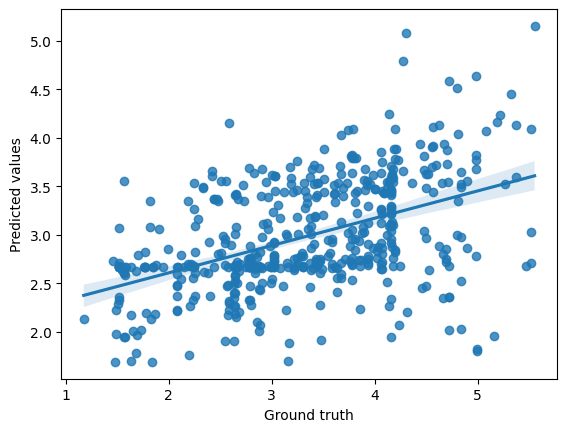

In [80]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)
fig.set(xlabel='Ground truth', ylabel='Predicted values')